In [1]:
def generate_bell_curve_temporal_graph(n_nodes=1000, n_edges=1_000_000, seed=42, time_range=1_000_000):
    np.random.seed(seed)

    # Bell-curve over node indices (higher probability for middle nodes)
    node_probs = np.exp(-0.5 * ((np.arange(n_nodes) - n_nodes / 2) / (n_nodes / 6)) ** 2)
    node_probs /= node_probs.sum()

    sources = np.random.choice(n_nodes, size=n_edges, p=node_probs)
    targets = np.random.choice(n_nodes, size=n_edges, p=node_probs)

    # Remove self-loops
    mask = sources != targets
    sources = sources[mask]
    targets = targets[mask]

    # Assign random timestamps in range [0, time_range)
    timestamps = np.random.randint(0, high=time_range, size=len(sources))

    return sources, targets, timestamps

def plot_node_distributions(edge_node_counts, walk_node_counts):
    nodes = np.arange(1000)

    plt.figure(figsize=(14, 6))

    plt.plot(nodes, edge_node_counts, label="Edge Participation Count", linewidth=2, alpha=0.8)
    plt.plot(nodes, walk_node_counts, label="Walk Visit Count", linewidth=2, alpha=0.8)
    plt.xlabel("Node ID")
    plt.ylabel("Frequency")
    plt.title("Node Participation: Edges vs Temporal Walks (Exponential Bias)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("plots/synthetic_uniform_walk_vs_edge_distribution.png")
    plt.show()

Generating graph...
ExponentialIndex → Avg walk length: 96.31
Linear → Avg walk length: 15.27
Uniform → Avg walk length: 9.97


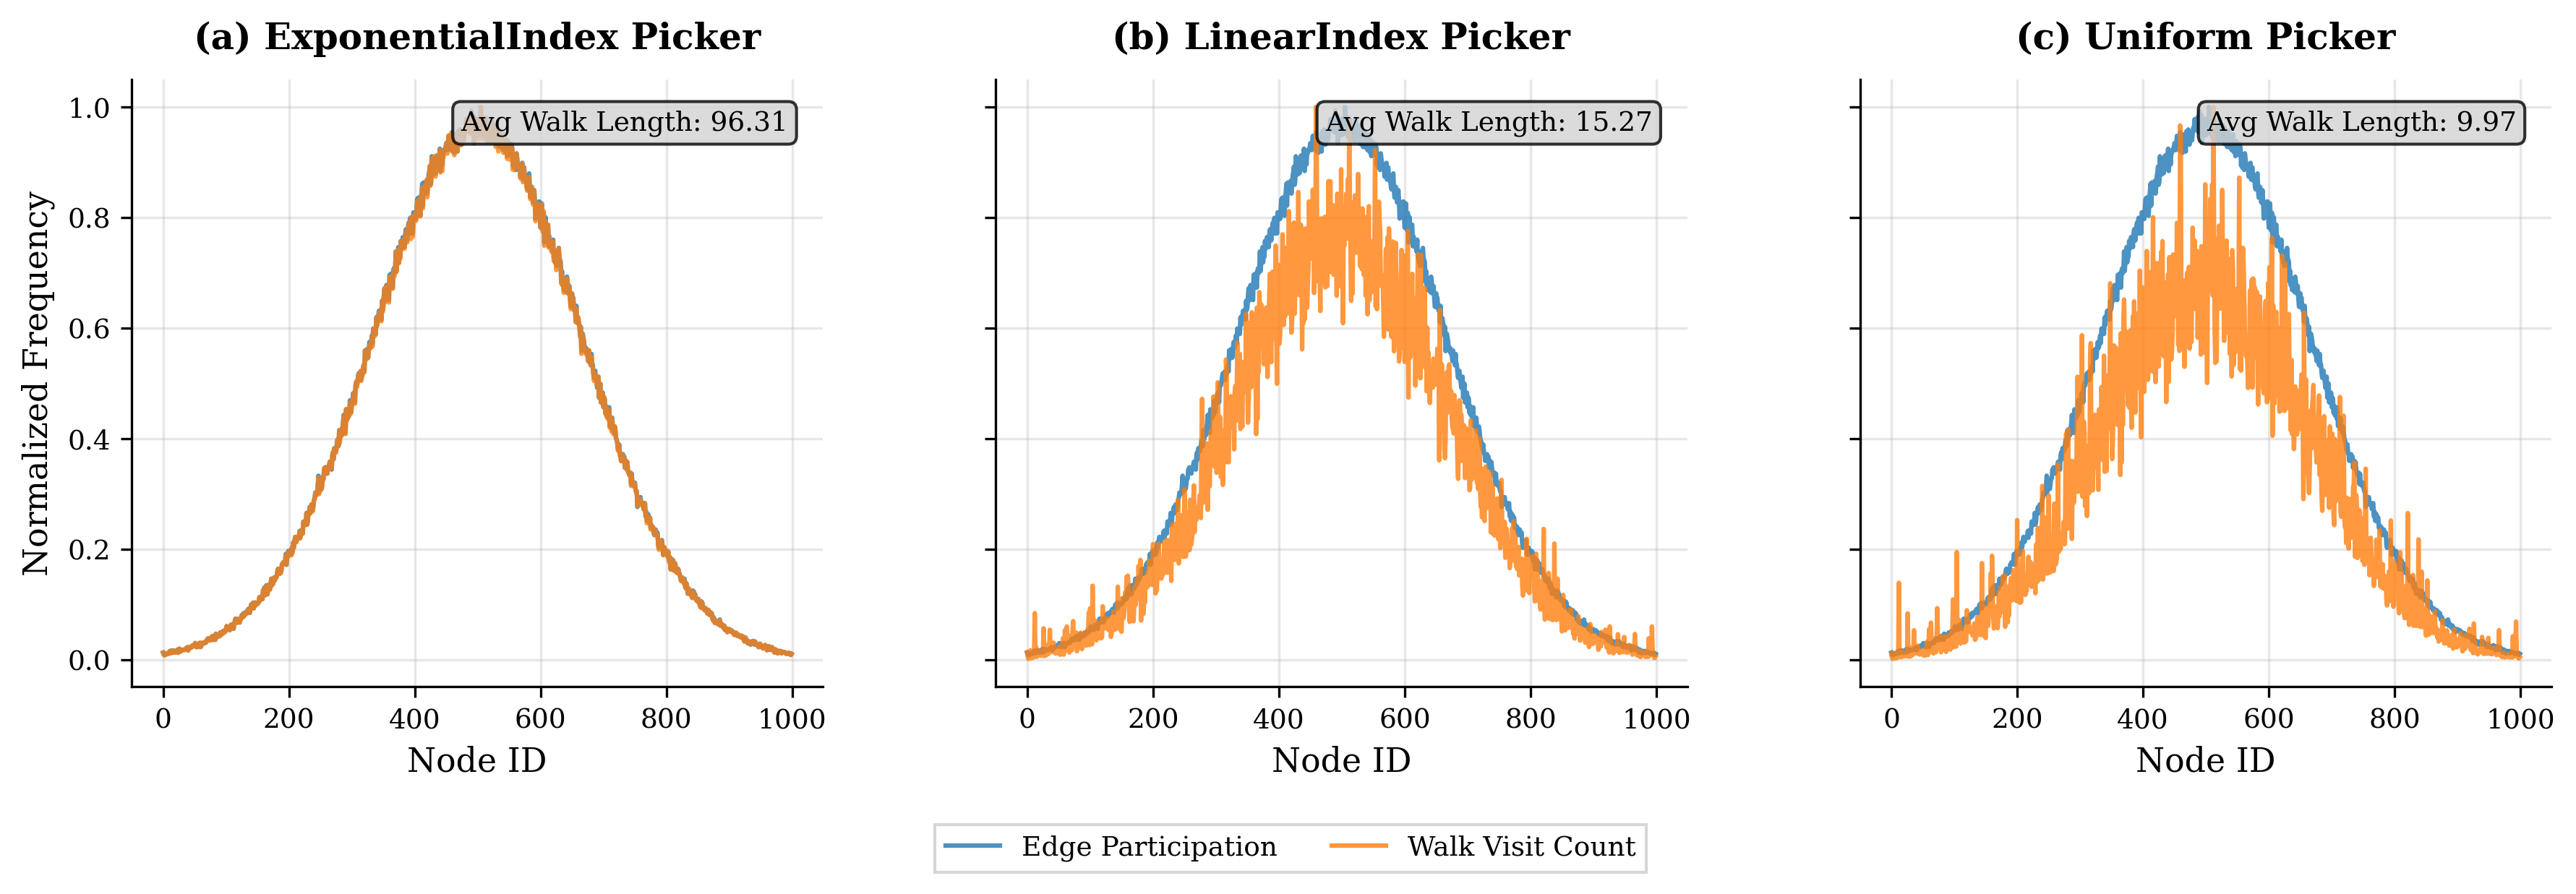

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from temporal_random_walk import TemporalRandomWalk

# Configure fonts and style for academic paper - matching other plots
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    'text.usetex': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

def run_walk_sampling(edge_picker, sources, targets, timestamps, n_nodes=1000):
    trw = TemporalRandomWalk(
        is_directed=False,
        use_gpu=False,
        max_time_capacity=-1,
        enable_weight_computation=True
    )
    trw.add_multiple_edges(sources, targets, timestamps)

    walks, _, walk_lengths = trw.get_random_walks_and_times(
        max_walk_len=100,
        walk_bias=edge_picker,
        num_walks_total=1_000_000,
        initial_edge_bias="Uniform",
        walk_direction="Forward_In_Time"
    )

    avg_walk_length = walk_lengths.mean()
    print(f"{edge_picker} → Avg walk length: {avg_walk_length:.2f}")

    edge_node_counts = np.zeros(n_nodes)
    for node in np.concatenate([sources, targets]):
        edge_node_counts[node] += 1

    valid_steps = walks[walks != -1]
    walk_node_counts = np.zeros(n_nodes)
    for node in valid_steps:
        walk_node_counts[node] += 1

    edge_node_counts /= edge_node_counts.max()
    walk_node_counts /= walk_node_counts.max()

    return edge_node_counts, walk_node_counts, avg_walk_length

def plot_all_distributions(results, n_nodes=1000):
    pickers = ["ExponentialIndex", "LinearIndex", "Uniform"]

    # Create 1x3 subplot with academic styling
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

    # Academic color scheme
    colors = ['#1f77b4', '#ff7f0e']  # Blue, Orange

    for i, (edge_counts, walk_counts, avg_walk_length) in enumerate(results):
        axs[i].plot(np.arange(n_nodes), edge_counts,
                   label="Edge Participation", linewidth=1.5, alpha=0.8, color=colors[0])
        axs[i].plot(np.arange(n_nodes), walk_counts,
                   label="Walk Visit Count", linewidth=1.5, alpha=0.8, color=colors[1])

        axs[i].set_title(f"({chr(97+i)}) {pickers[i]} Picker", fontweight='bold', pad=10)
        axs[i].set_xlabel("Node ID")

        if i == 0:
            axs[i].set_ylabel("Normalized Frequency")

        axs[i].grid(True, alpha=0.3)
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].ticklabel_format(style='plain', axis='both')

        # Add average walk length text box
        axs[i].text(0.95, 0.95, f'Avg Walk Length: {avg_walk_length:.2f}',
                   transform=axs[i].transAxes, fontsize=9,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.8))

    # Add single legend at bottom for all subplots - moved lower
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels,
              loc='lower center',
              bbox_to_anchor=(0.5, -0.05),
              ncol=2,
              frameon=True,
              fancybox=False,
              fontsize=9)

    # Adjust layout - matching other plots
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25, top=0.88, bottom=0.18)

    # Save with high quality
    plt.savefig("figures/walk_distribution_comparison.pdf", format='pdf', bbox_inches='tight')
    plt.savefig("figures/walk_distribution_comparison.png", format='png', bbox_inches='tight')
    plt.show()

def run_bell_curve_walk_distribution_experiment():
    print("Generating graph...")
    sources, targets, timestamps = generate_bell_curve_temporal_graph()
    pickers = ["ExponentialIndex", "Linear", "Uniform"]
    results = []

    for picker in pickers:
        edge_counts, walk_counts, avg_walk_length = run_walk_sampling(picker, sources, targets, timestamps)
        results.append((edge_counts, walk_counts, avg_walk_length))

    plot_all_distributions(results)

# Run it
run_bell_curve_walk_distribution_experiment()

In [8]:
import pandas as pd
import os

data_dir = '/Users/ashfaqsalehin/Downloads/TEA-datasets/datasets'

In [9]:
df = pd.read_csv(os.path.join(data_dir, 'out.wikipedia-growth'),
                               sep=r'\s+',
                               skiprows=2,
                               header=None,
                               names=['u', 'i', 'x', 'ts'])

In [10]:
df

,u,i,x,ts
0,1,3,1,982623600
1,4,5,1,982623600
2,1,6,1,982710000
3,1,7,1,982710000
4,1,8,1,982710000
...,...,...,...,...
39953139,1870449,477195,1,1175810400
39953140,889373,415129,1,1175810400
39953141,889373,1870666,1,1175810400
39953142,259241,244935,1,1175810400


In [11]:
df[['u', 'i', 'ts']].to_csv('/Users/ashfaqsalehin/Downloads/TEA-datasets/csv_datasets/growth.csv', index=False)

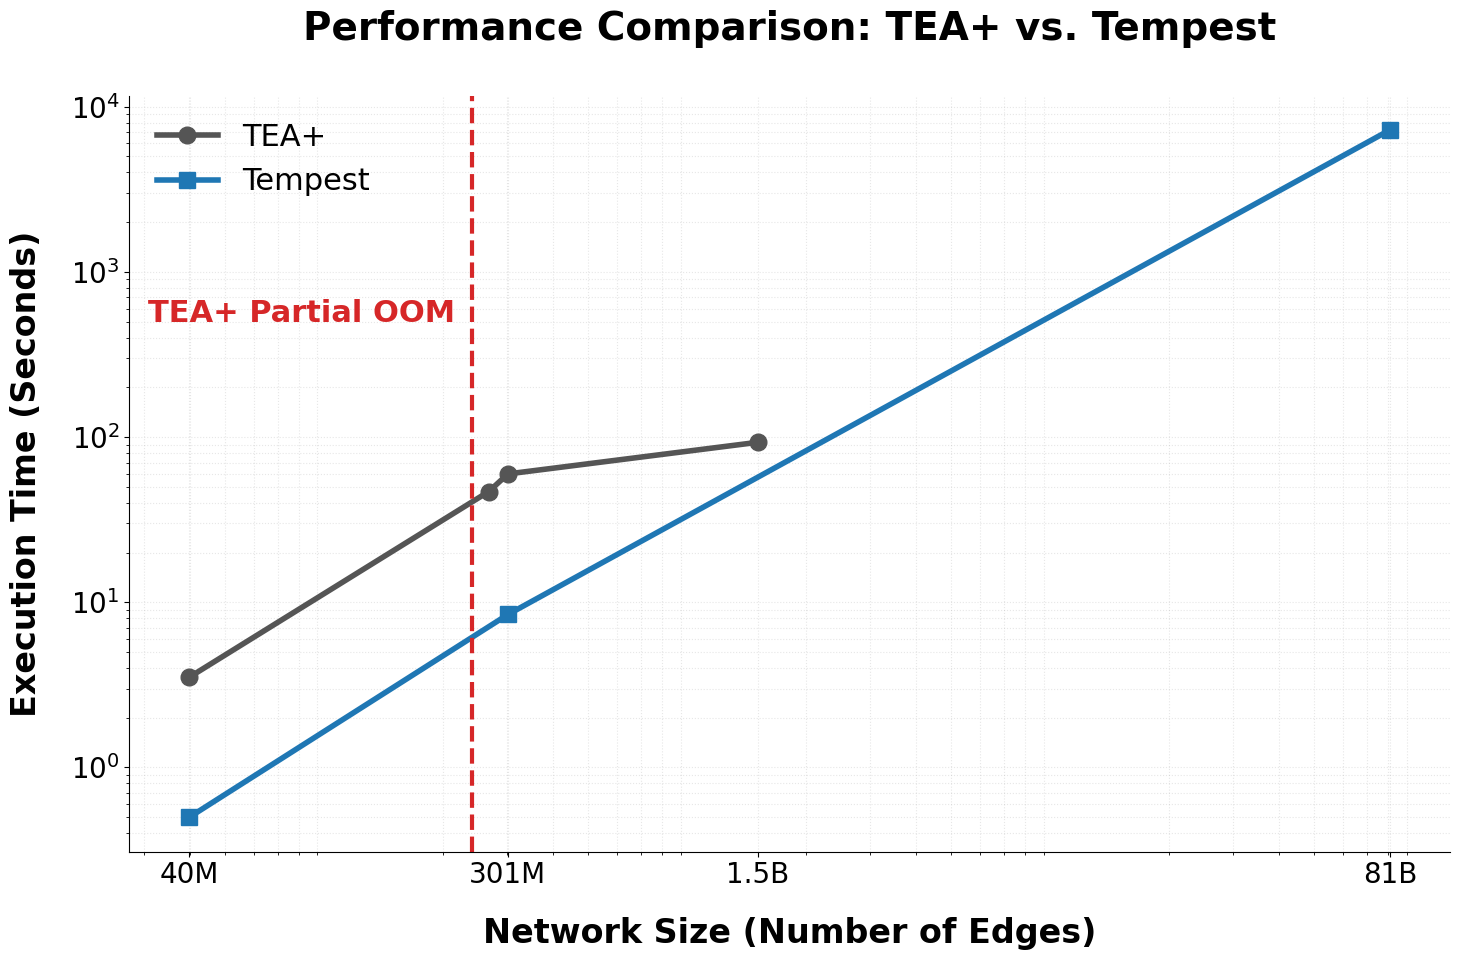

In [5]:
import matplotlib.pyplot as plt

# Data points based on TEA paper and User Data
edges_growth = 39.95e6
edges_edit = 266.77e6
edges_delicious = 301.18e6
edges_twitter = 1.468e9
edges_alibaba = 81e9

# TEA+ Runtimes (Y)
teaplus_x = [edges_growth, edges_edit, edges_delicious, edges_twitter]
teaplus_y = [3.52, 46.81, 59.82, 92.93]

# Tempest Runtimes (Y)
tempest_x = [edges_growth, edges_delicious, edges_alibaba]
tempest_y = [0.5, 8.43, 7236.0] # 2.01 hours

# High-quality presentation settings with large text
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'sans-serif',
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 22
})

fig, ax = plt.subplots(figsize=(15, 10))

# Plot TEA+ (Grey Line)
ax.plot(teaplus_x, teaplus_y, marker='o', linestyle='-', color='#555555',
        label='TEA+', linewidth=4, markersize=12)

# Plot Tempest (Blue Line) - No interpolation
ax.plot(tempest_x, tempest_y, marker='s', linestyle='-', color='#1f77b4',
        label='Tempest', linewidth=4, markersize=12)

oom_wall_x = 240e6
ax.axvline(x=oom_wall_x, color='#d62728', linestyle='--', linewidth=3)
ax.text(oom_wall_x * 0.9, 500, 'TEA+ Partial OOM', color='#d62728', fontweight='bold',
        fontsize=22, horizontalalignment='right')

# Log-Log scale for massive ranges
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Network Size (Number of Edges)', fontweight='bold', labelpad=20)
ax.set_ylabel('Execution Time (Seconds)', fontweight='bold', labelpad=20)
ax.set_title('Performance Comparison: TEA+ vs. Tempest', fontweight='bold', pad=40)

# Custom Ticks - Only 40M, 301M, 1.5B, 81B (Omit 267M)
display_ticks = [edges_growth, edges_delicious, edges_twitter, edges_alibaba]
ax.set_xticks(display_ticks)

# Format ticks to M/B and keep horizontal
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(
    lambda x, p: f'{x/1e6:.0f}M' if x < 1e9 else (f'{x/1e9:.1f}B' if x < 10e9 else f'{x/1e9:.0f}B')))

plt.xticks(rotation=0)

# Legend and Aesthetics
ax.legend(loc='upper left', frameon=False)
ax.grid(True, which='both', linestyle=':', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('tempest_reveal_final.png', dpi=300)

In [44]:
import pickle
import numpy as np
import matplotlib.pyplot as plt


def plot_window_sensitivity_results(results_path):
    # --------------------------
    # Load results
    # --------------------------
    with open(results_path, "rb") as f:
        results = pickle.load(f)

    # Sort relative history DESCENDING (e.g. 100 → 10)
    rel_h = sorted(results.keys(), reverse=True)

    ingestion_mean = [results[h]["ingestion_time_mean"] for h in rel_h]
    ingestion_std  = [results[h]["ingestion_time_std"]  for h in rel_h]

    walk_mean = [results[h]["walk_sampling_time_mean"] for h in rel_h]
    walk_std  = [results[h]["walk_sampling_time_std"]  for h in rel_h]

    auc_mean = [results[h]["auc_mean"] for h in rel_h]
    auc_std  = [results[h]["auc_std"]  for h in rel_h]

    # --------------------------
    # Plot
    # --------------------------
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    # Ingestion time
    axes[0].errorbar(rel_h, ingestion_mean, yerr=ingestion_std, fmt='o-')
    axes[0].set_title("Ingestion Time")
    axes[0].set_xlabel("Relative history (T/Δ)")
    axes[0].set_ylabel("Time (seconds)")
    axes[0].grid(True)

    # Walk sampling time
    axes[1].errorbar(rel_h, walk_mean, yerr=walk_std, fmt='o-')
    axes[1].set_title("Walk Sampling Time")
    axes[1].set_xlabel("Relative history (T/Δ)")
    axes[1].set_ylabel("Time (seconds)")
    axes[1].grid(True)

    # AUC
    axes[2].errorbar(rel_h, auc_mean, yerr=auc_std, fmt='o-')
    axes[2].set_title("Link Prediction AUC")
    axes[2].set_xlabel("Relative history (T/Δ)")
    axes[2].set_ylabel("AUC")
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

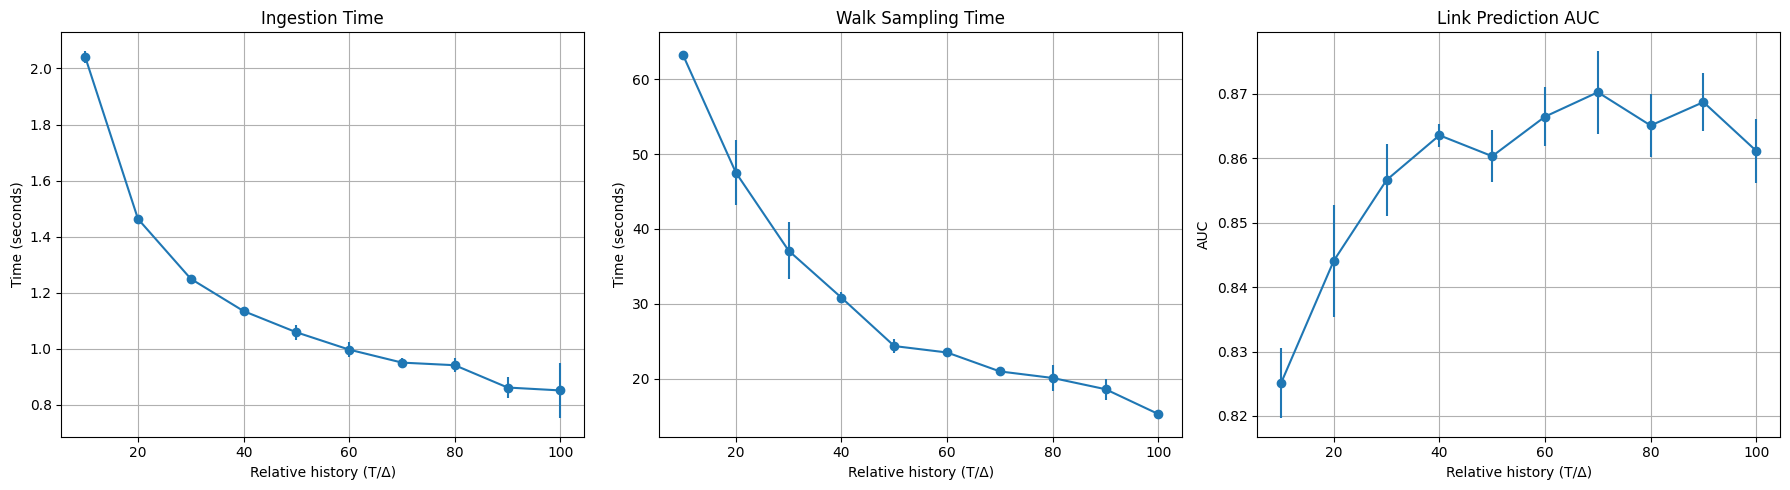

In [45]:
plot_window_sensitivity_results("results/tgbl_coin_window_sensitivity_3_1_10.pickle")

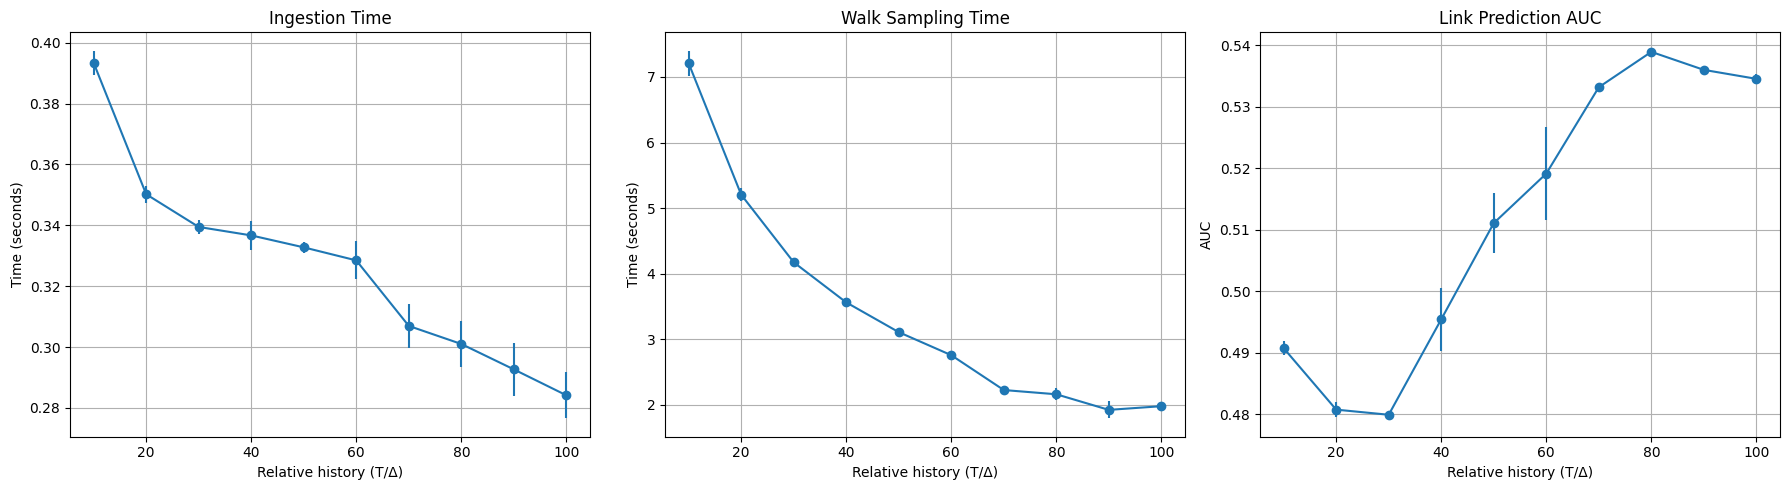

In [46]:
plot_window_sensitivity_results('results/tgbl_comment_window_sensitivity_3_1_10_1.pickle')

In [71]:
import pickle
import matplotlib.pyplot as plt


def plot_combined_window_sensitivity(results_dict):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    handles = []
    labels = []

    for dataset_name, results_path in results_dict.items():
        with open(results_path, "rb") as f:
            results = pickle.load(f)

        # Ascending for correct geometry; invert axis later
        rel_h = sorted(results.keys())

        ingestion_mean = [results[h]["ingestion_time_mean"] for h in rel_h]
        ingestion_std  = [results[h]["ingestion_time_std"]  for h in rel_h]

        walk_mean = [results[h]["walk_sampling_time_mean"] for h in rel_h]
        walk_std  = [results[h]["walk_sampling_time_std"]  for h in rel_h]

        auc_mean = [results[h]["auc_mean"] for h in rel_h]
        auc_std  = [results[h]["auc_std"]  for h in rel_h]

        # --------------------------
        # Main curves
        # --------------------------
        h = axes[0].errorbar(
            rel_h, ingestion_mean, yerr=ingestion_std,
            fmt='o-', linewidth=1.5, markersize=4,
            capsize=2, elinewidth=1
        )

        axes[1].errorbar(
            rel_h, walk_mean, yerr=walk_std,
            fmt='o-', linewidth=1.5, markersize=4,
            capsize=2, elinewidth=1
        )

        axes[2].errorbar(
            rel_h, auc_mean, yerr=auc_std,
            fmt='o-', linewidth=1.5, markersize=4,
            capsize=2, elinewidth=1
        )

        color = h.lines[0].get_color()

        # --------------------------
        # Optimal points
        # --------------------------
        # Ingestion: min
        idx_ing = min(range(len(ingestion_mean)), key=lambda i: ingestion_mean[i])
        axes[0].scatter(
            rel_h[idx_ing], ingestion_mean[idx_ing],
            marker="*", s=140, color=color, zorder=5
        )

        # Walk sampling: min
        idx_walk = min(range(len(walk_mean)), key=lambda i: walk_mean[i])
        axes[1].scatter(
            rel_h[idx_walk], walk_mean[idx_walk],
            marker="*", s=140, color=color, zorder=5
        )

        # AUC: max
        idx_auc = max(range(len(auc_mean)), key=lambda i: auc_mean[i])
        axes[2].scatter(
            rel_h[idx_auc], auc_mean[idx_auc],
            marker="*", s=140, color=color, zorder=5
        )

        handles.append(h)
        labels.append(dataset_name)

    # --------------------------
    # Axes formatting
    # --------------------------
    axes[0].set_title("Ingestion Time")
    axes[1].set_title("Walk Sampling Time")
    axes[2].set_title("Link Prediction AUC")

    axes[0].set_ylabel("Time (seconds)")
    axes[1].set_ylabel("Time (seconds)")
    axes[2].set_ylabel("AUC")

    for ax in axes:
        ax.set_xlabel("Relative history (T/Δ)")
        ax.grid(True, alpha=0.3)
        ax.invert_xaxis()  # 100 → 10

    # Scales
    axes[0].set_yscale("log")   # ingestion
    # axes[1] linear
    # axes[2] linear

    # Global legend
    fig.legend(
        handles, labels,
        title="Dataset",
        loc="center right",
        bbox_to_anchor=(1.02, 0.5)
    )

    plt.tight_layout(rect=[0, 0, 0.92, 1])
    plt.show()

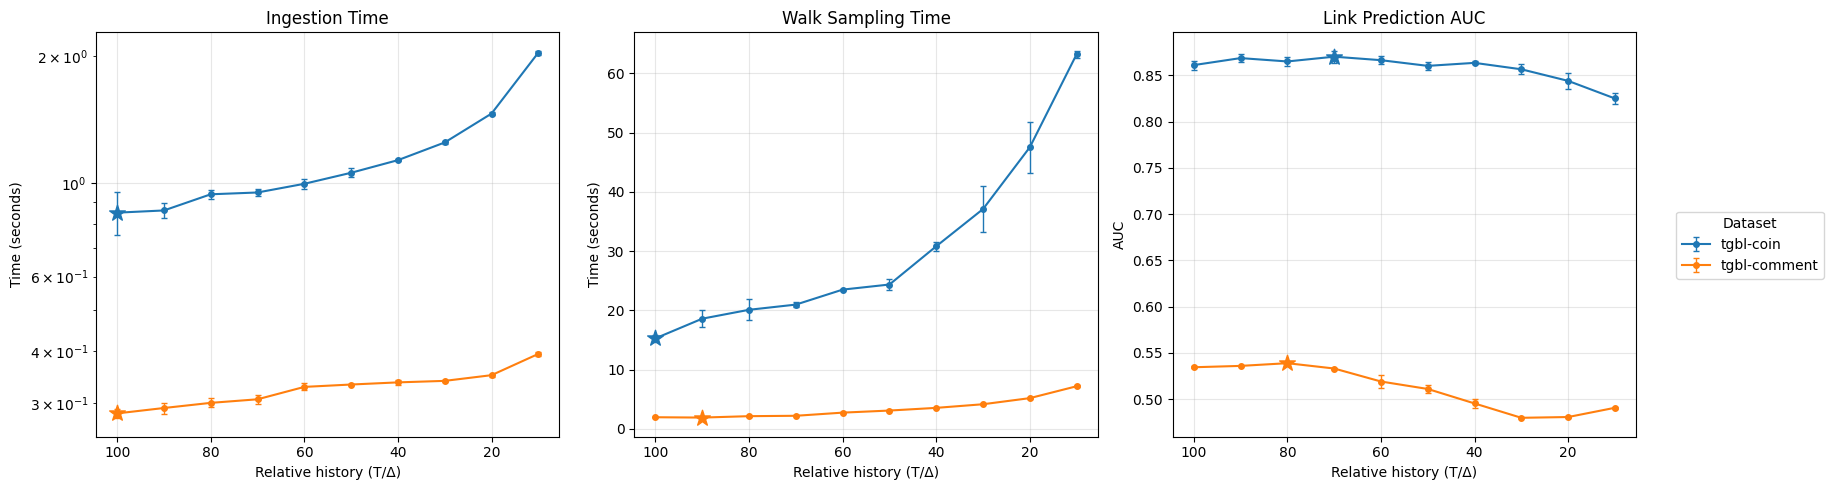

In [72]:
plot_combined_window_sensitivity({
    'tgbl-coin': 'results/tgbl_coin_window_sensitivity_3_1_10.pickle',
    'tgbl-comment': 'results/tgbl_comment_window_sensitivity_3_1_10_1.pickle'
})

In [70]:
import pickle

with open('results/tgbl_coin_window_sensitivity_3_1_10.pickle', 'rb') as f:
    tgbl_coin_results = pickle.load(f)

with open('results/tgbl_comment_window_sensitivity_3_1_10_1.pickle', 'rb') as f:
    tgbl_comment_results = pickle.load(f)

In [74]:
with open('/Users/ashfaqsalehin/Downloads/tgbl_flight_window_sensitivity_3_1_10.pickle', 'rb') as f:
    tgbl_flight_results = pickle.load(f)

In [75]:
tgbl_flight_results

{100: {'window_duration': 839772,
  'ingestion_time_mean': 1.2833921446775396,
  'ingestion_time_std': 0.26597147360177975,
  'walk_sampling_time_mean': 2.1209190365237496,
  'walk_sampling_time_std': 0.030738904347935574,
  'auc_mean': 0.9707457111744903,
  'auc_std': 0.001310094272336578},
 90: {'window_duration': 933080,
  'ingestion_time_mean': 1.1458882023580372,
  'ingestion_time_std': 0.025754435634781307,
  'walk_sampling_time_mean': 2.290295548737049,
  'walk_sampling_time_std': 0.2124735835957229,
  'auc_mean': 0.971288155020472,
  'auc_std': 0.000368721318195207},
 80: {'window_duration': 1049715,
  'ingestion_time_mean': 1.2285534509768088,
  'ingestion_time_std': 0.016715595452975393,
  'walk_sampling_time_mean': 2.3944530193693936,
  'walk_sampling_time_std': 0.21227194029611443,
  'auc_mean': 0.9711895241437517,
  'auc_std': 0.0006438954784148559},
 70: {'window_duration': 1199674,
  'ingestion_time_mean': 1.2638376670268674,
  'ingestion_time_std': 0.028489839516358723,

In [76]:
tgbl_flight_results[80]['auc_mean'] = 0.971288155020472
tgbl_flight_results[90]['auc_mean'] = 0.9711895241437517

In [78]:
with open('results/tgbl_flight_window_sensitivity_3_1_10.pickle', 'wb') as f:
    pickle.dump(tgbl_flight_results, f)

In [79]:
tgbl_flight_results

{100: {'window_duration': 839772,
  'ingestion_time_mean': 1.2833921446775396,
  'ingestion_time_std': 0.26597147360177975,
  'walk_sampling_time_mean': 2.1209190365237496,
  'walk_sampling_time_std': 0.030738904347935574,
  'auc_mean': 0.9707457111744903,
  'auc_std': 0.001310094272336578},
 90: {'window_duration': 933080,
  'ingestion_time_mean': 1.1458882023580372,
  'ingestion_time_std': 0.025754435634781307,
  'walk_sampling_time_mean': 2.290295548737049,
  'walk_sampling_time_std': 0.2124735835957229,
  'auc_mean': 0.9711895241437517,
  'auc_std': 0.000368721318195207},
 80: {'window_duration': 1049715,
  'ingestion_time_mean': 1.2285534509768088,
  'ingestion_time_std': 0.016715595452975393,
  'walk_sampling_time_mean': 2.3944530193693936,
  'walk_sampling_time_std': 0.21227194029611443,
  'auc_mean': 0.971288155020472,
  'auc_std': 0.0006438954784148559},
 70: {'window_duration': 1199674,
  'ingestion_time_mean': 1.2638376670268674,
  'ingestion_time_std': 0.028489839516358723,